# Исследование базы данных Stackoverflow

В этом исследовании работа идёт с базой данных StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.     
Я исследовала предоставленные данные, сформировала требуемые выгрузки данных с помощью SQL, посчитала различные продуктовые метрики и визуализировала их с помощью библиотек matplotlib, seaborn.

К БД подключилась с помощью SQLAlchemy. 

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к БД 'data-analyst-advanced-sql', cxема stackoverflow

In [22]:
db_config = {
    'user': 'praktikum_student', 
    'pwd': '****************, 
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-analyst-advanced-sql' 
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [23]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [24]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date month_date, 
	   sum(views_count) views_total
FROM stackoverflow.posts p 
WHERE EXTRACT (YEAR FROM creation_date) = '2008'
GROUP BY month_date
ORDER BY views_total DESC
'''

# выполните запрос
df_task1 = pd.read_sql_query(query, con=engine) 
df_task1

,month_date,views_total
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [25]:
# напишите запрос
query = '''
WITH raw AS 
	(SELECT u.id user_id, u.creation_date :: date, u.display_name,
		   p.id post_id, 
		   p.creation_date :: date post_dt
	FROM stackoverflow.posts p
	JOIN stackoverflow.users u ON u.id = p.user_id
	WHERE post_type_id IN (SELECT id 
							FROM stackoverflow.post_types 
							WHERE TYPE = 'Answer')
	AND p.creation_date BETWEEN u.creation_date AND u.creation_date + INTERVAL '30 days')
SELECT display_name, count(DISTINCT user_id) 
FROM raw
GROUP BY display_name
HAVING count(post_id) > 100
ORDER BY display_name

'''

# выполните запрос
df_task2 = pd.read_sql_query(query, con=engine) 
df_task2.head()

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8


# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [26]:
# напишите запрос
query = '''
-- users who registered 09/2008						
WITH users as
	(SELECT id user_id, creation_date :: date
	FROM stackoverflow.users
	WHERE DATE_TRUNC('month', creation_date) = '2008-09-01'),
-- users who had posts at 12/2008	
users_list AS 	
	(SELECT DISTINCT u.user_id
	FROM users u
	JOIN stackoverflow.posts p ON u.user_id = p.user_id 
	WHERE DATE_TRUNC('month', p.creation_date) = '2008-12-01')
-- count of posts by users_list
SELECT cast(date_trunc('month', p.creation_date) AS date) month_date, count(p.id)
FROM users_list u
JOIN stackoverflow.posts p ON u.user_id = p.user_id 
GROUP BY month_date
ORDER BY month_date DESC 
'''

# выполните запрос
df_task3 = pd.read_sql_query(query, con=engine) 
df_task3

,month_date,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [27]:
# напишите запрос
query = '''
SELECT user_id, creation_date, views_count, 
	   sum(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполните запрос
df_task4 = pd.read_sql_query(query, con=engine) 
df_task4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [28]:
# напишите запрос
query = '''
WITH raw AS 
	(SELECT user_id, creation_date :: date, count(id) daily_count
	FROM stackoverflow.posts p 
	WHERE user_id IN (SELECT user_id
		FROM stackoverflow.posts
		WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
		GROUP BY user_id
		HAVING count(id) > 120)
	AND DATE_TRUNC('month', creation_date) = '2008-08-01'
	GROUP BY 1, 2)
SELECT user_id, avg(daily_count) avg_daily
FROM raw
GROUP BY user_id
ORDER BY avg_daily
'''

# выполните запрос
df_task5 = pd.read_sql_query(query, con=engine) 
df_task5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [29]:
# напишите запрос
query = '''
SELECT round(avg(days))
FROM (WITH raw AS
		(SELECT DISTINCT user_id, creation_date :: date AS dt
		FROM stackoverflow.posts p 
		WHERE creation_date :: date BETWEEN to_date('01122008', 'ddmmyyyy') AND to_date('07122008', 'ddmmyyyy'))
	SELECT user_id, count(dt) days
	FROM raw
	GROUP BY user_id) x
'''

# выполните запрос
df_task6 = pd.read_sql_query(query, con=engine) 
df_task6

,round
0,2.0


# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [30]:
# напишите запрос
query = '''
SELECT user_id, creation_date post_dt,
	   to_char(lag(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month') second_last_month
FROM stackoverflow.posts p 
ORDER BY user_id
'''

# выполните запрос
df_task7 = pd.read_sql_query(query, con=engine) 
df_task7.head(10)

,user_id,post_dt,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
5,1,2008-08-04 08:04:42,August
6,1,2008-08-10 08:28:52,August
7,1,2008-08-11 19:23:47,August
8,1,2008-08-12 00:30:43,August
9,1,2008-08-12 04:59:35,August


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [31]:
# напишите запрос
query = '''
WITH cohorts as
	(SELECT x.*, count(user_id) OVER (PARTITION BY cohort_dt) cohort_users_cnt
	FROM (SELECT DISTINCT user_id, 
		   		 CAST(date_trunc('month', min(creation_date) OVER (PARTITION BY user_id ORDER BY creation_date)) AS date) cohort_dt
		  FROM stackoverflow.posts) x),
sessions as
	(SELECT user_id, cast(date_trunc('month', creation_date) AS date) session_dt
	FROM stackoverflow.posts 
	GROUP BY 1, 2)
SELECT c.cohort_dt, 
	   s.session_dt, 
	   count(c.user_id) users_cnt,
	   cohort_users_cnt, 
	   round(count(c.user_id) * 100.0 / cohort_users_cnt, 2) retention_rate 
FROM cohorts c
JOIN sessions s ON c.user_id = s.user_id
GROUP BY 1, 2, 4
'''

# выполните запрос
df_task8 = pd.read_sql_query(query, con=engine) 
df_task8.head(10)

,cohort_dt,session_dt,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

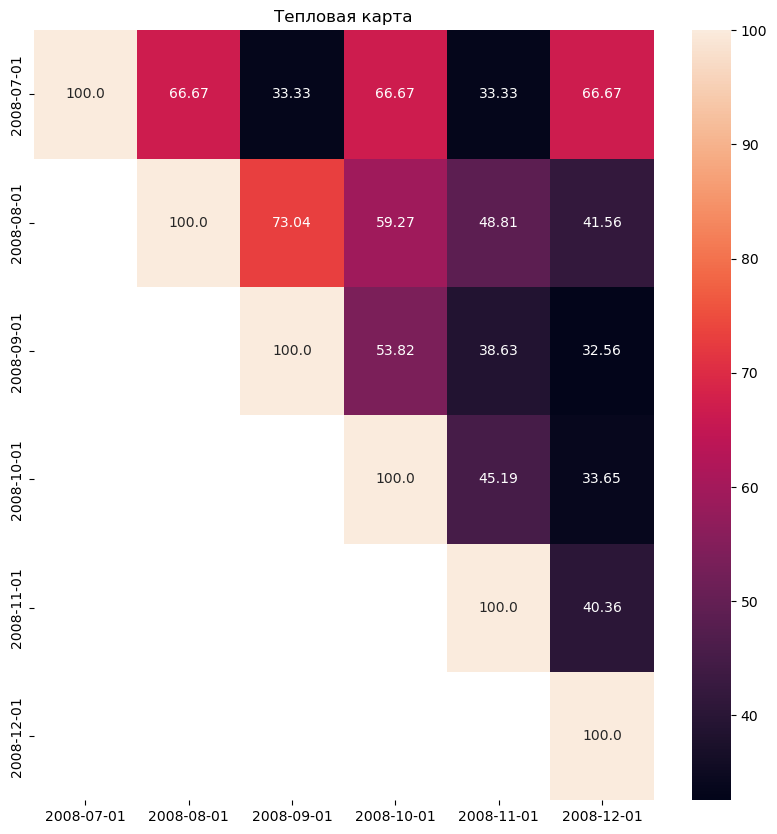

In [32]:
# постройте тепловую карту Retention Rate
# создаём сводную таблицу с результатами
retention = df_task8.pivot('cohort_dt', 'session_dt', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(10, 10)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') 
plt.show()

In [33]:
# опишите аномалии или другие необычные явления и сформулируйте гипотезы

<div class="alert alert-block alert-info">

По хитмэпу активность июльских пользователей может показаться аномальной, но т.к. в июле у нас была небольшая выборка пользователей, эти отклонения можно не учитывать ввиду нерепрезентативности базы. 
 
По остальным данным видно снижение коэффициента удержания на второй месяц с августа по ноябрь, с 73% до 40% соотвественно. 
</div>

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [34]:
# напишите запрос
query = '''
SELECT month_number, posts_cnt, round((difference_perc * 100), 2) percentage
FROM 
	(WITH raw AS 
		(SELECT EXTRACT(MONTH FROM (cast(date_trunc('month', creation_date) AS date))) month_number, count(id) posts_cnt
		FROM stackoverflow.posts
		WHERE creation_date :: date BETWEEN to_date('01092008', 'ddmmyyyy') AND to_date('31122008', 'ddmmyyyy')
		GROUP BY 1
		ORDER BY 1)
	SELECT *, lag(posts_cnt) OVER (ORDER BY month_number),
		   (posts_cnt - lag(posts_cnt) OVER (ORDER BY month_number)) difference,
		   (posts_cnt - lag(posts_cnt) OVER (ORDER BY month_number)) :: numeric / lag(posts_cnt) OVER (ORDER BY month_number) difference_perc
	FROM raw) x
'''

# выполните запрос
df_task9 = pd.read_sql_query(query, con=engine) 
df_task9

,month_number,posts_cnt,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

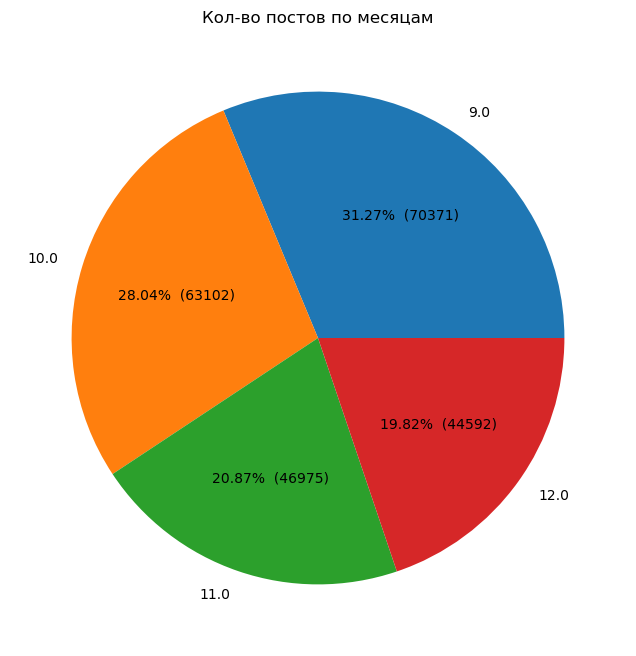

In [35]:
# постройте круговую диаграмму с количеством постов по месяцам

posts_cnt = df_task9['posts_cnt']
labels = df_task9['month_number']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# строим piechart
plt.figure(figsize=(8, 8)) 
plt.title('Кол-во постов по месяцам') 

plt.pie(posts_cnt, labels=labels, autopct=make_autopct(posts_cnt))
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [36]:
# напишите запрос
query = '''
SELECT DISTINCT date_part('week', creation_date) week_num,
	   max(creation_date) OVER (PARTITION BY date_part('week', creation_date))
FROM stackoverflow.posts 
WHERE date_trunc('month', creation_date) = '2008-10-01' 
AND user_id IN (SELECT user_id
				FROM stackoverflow.posts
				GROUP BY user_id
				ORDER BY count(id) DESC
				LIMIT 1)

'''

# выполните запрос
df_task10 = pd.read_sql_query(query, con=engine) 
df_task10

,week_num,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
